# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [41]:
# These two are required to work in local mode
# in my laptop
import findspark
findspark.init()

# All libraries required fo rthis analysis
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, StringType
from pyspark.ml.classification import RandomForestClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb

# I like inline plots
%matplotlib inline

# Setting to display max column width
pd.set_option('display.max_colwidth', None)

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

In [3]:
# To show output to fit Jupyter notebook
# ref: https://stackoverflow.com/questions/50523950/improve-pyspark-dataframe-show-output-to-fit-jupyter-notebook
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# Let's look the first 5 rows of the file
!head -n 5 mini_sparkify_event_data.json

{"ts":1538352117000,"userId":"30","sessionId":29,"page":"NextSong","auth":"Logged In","method":"PUT","status":200,"level":"paid","itemInSession":50,"location":"Bakersfield, CA","userAgent":"Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0","lastName":"Freeman","firstName":"Colin","registration":1538173362000,"gender":"M","artist":"Martha Tilston","song":"Rockpools","length":277.89016}
{"ts":1538352180000,"userId":"9","sessionId":8,"page":"NextSong","auth":"Logged In","method":"PUT","status":200,"level":"free","itemInSession":79,"location":"Boston-Cambridge-Newton, MA-NH","userAgent":"\"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36\"","lastName":"Long","firstName":"Micah","registration":1538331630000,"gender":"M","artist":"Five Iron Frenzy","song":"Canada","length":236.09424}
{"ts":1538352394000,"userId":"30","sessionId":29,"page":"NextSong","auth":"Logged In","method":"PUT","status":200,"level":"pai

In [71]:
# Cerate a Dataframe reading the JSON file
df = spark.read.json('mini_sparkify_event_data.json')

In [72]:
# Check first 5 rows
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [73]:
# print the dataset schema to check columns types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [74]:
# Let's print total number of rows and columns
print("Total number fo rows: {}\nNumber of columns: {}".format(df.count(), len(df.columns)))

Total number fo rows: 286500
Number of columns: 18


In [75]:
# Convert it to Pandas to do a quick check
pd_df = df.toPandas()

In [76]:
# I like to see the data info provides in contrast to Spark's
# that looks incomplete
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   artist         228108 non-null  object 
 1   auth           286500 non-null  object 
 2   firstName      278154 non-null  object 
 3   gender         278154 non-null  object 
 4   itemInSession  286500 non-null  int64  
 5   lastName       278154 non-null  object 
 6   length         228108 non-null  float64
 7   level          286500 non-null  object 
 8   location       278154 non-null  object 
 9   method         286500 non-null  object 
 10  page           286500 non-null  object 
 11  registration   278154 non-null  float64
 12  sessionId      286500 non-null  int64  
 13  song           228108 non-null  object 
 14  status         286500 non-null  int64  
 15  ts             286500 non-null  int64  
 16  userAgent      278154 non-null  object 
 17  userId         286500 non-nul

In [77]:
# Pandas describe gives lots of good information I like to see
# like unique values per column, count (and NaN by default) etc.
pd_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
artist,228108,17655,Kings Of Leon,1841,NaN,NaN,NaN,NaN,NaN,NaN,NaN
auth,286500,4,Logged In,278102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
firstName,278154,189,Payton,9632,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,278154,2,F,154578,NaN,NaN,NaN,NaN,NaN,NaN,NaN
itemInSession,286500,NaN,NaN,NaN,114.414,129.767,0,27,70,156.25,1321
lastName,278154,173,Campbell,14060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
length,228108,NaN,NaN,NaN,249.117,99.2352,0.78322,199.889,234.501,277.159,3024.67
level,286500,2,paid,228162,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,278154,114,"Los Angeles-Long Beach-Anaheim, CA",30131,NaN,NaN,NaN,NaN,NaN,NaN,NaN
method,286500,2,PUT,261064,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
# Based on the previous information I am exploring some columns I think
# are interesting or may add value to the prediction of churn
df.groupby('auth').count() \
.sort('count', ascending=False)

auth,count
Logged In,278102
Logged Out,8249
Guest,97
Cancelled,52


In [79]:
# I fill all null values in 'gender' column by 'U' -> Unspecified
df = df.fillna('U', subset='gender')

In [80]:
# and compute the distribution
df.groupby('gender').count().sort('count', ascending=False)

gender,count
F,154578
M,123576
U,8346


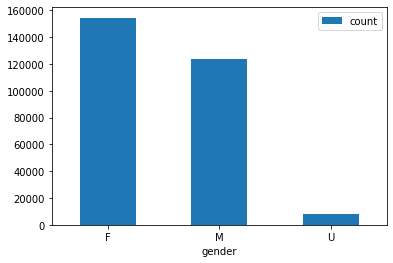

In [81]:
# with a graph as well
df.groupby('gender').count().sort('count', ascending=False) \
.toPandas().plot.bar(x='gender', y='count', rot=0);

In [82]:
# Let's see the 'level' distribution of subscribers
df.groupby('level').count().sort('level', ascending=[False])

level,count
paid,228162
free,58338


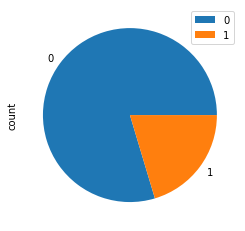

In [83]:
# A pie chart makes sense here, most of our users are paid users
df.groupby('level').count().sort('level', ascending=[False]) \
.toPandas().plot.pie(y='count');

In [84]:
# let's see what the 'location' column has to offer:
df.groupby('location').count().sort('count', ascending=[False]).show(20, False)

+-------------------------------------------+-----+
|location                                   |count|
+-------------------------------------------+-----+
|Los Angeles-Long Beach-Anaheim, CA         |30131|
|New York-Newark-Jersey City, NY-NJ-PA      |23684|
|Boston-Cambridge-Newton, MA-NH             |13873|
|Houston-The Woodlands-Sugar Land, TX       |9499 |
|null                                       |8346 |
|Charlotte-Concord-Gastonia, NC-SC          |7780 |
|Dallas-Fort Worth-Arlington, TX            |7605 |
|Louisville/Jefferson County, KY-IN         |6880 |
|Philadelphia-Camden-Wilmington, PA-NJ-DE-MD|5890 |
|Chicago-Naperville-Elgin, IL-IN-WI         |5114 |
|St. Louis, MO-IL                           |4858 |
|Phoenix-Mesa-Scottsdale, AZ                |4846 |
|Vineland-Bridgeton, NJ                     |4825 |
|Wilson, NC                                 |4659 |
|Denver-Aurora-Lakewood, CO                 |4453 |
|Ionia, MI                                  |4428 |
|San Antonio

In [85]:
# I am not sure how I am going to use this information (if I use it at all)
# So for now just extract the State information after the ',' with the below
# function
def split_location_by_state(df):
    
    # Replace the NaN values with the followin to extract the 'Other'
    # String to denotate a missing value or value not entered
    df = df.fillna('Nah, Other', subset='location')
    
    # Then I split the 'location' column bu ',' and extract the second
    # item, the state information
    # In multiple cases thsi is a group of various States together. I am
    # fine with that so far ...
    df = df.withColumn('state', split(df['location'], ',').getItem(1))
    
    # We return the modified Dataframe back
    return df

In [86]:
# Run the function in the dataframe
df = split_location_by_state(df)

In [198]:
# A quick check on our newly created column 
df.select('state').show(5, False)

+------+
|state |
+------+
| CA   |
| MA-NH|
| CA   |
| MA-NH|
| CA   |
+------+
only showing top 5 rows



In [210]:
df.groupby('state').count().sort('count', ascending=[False]).show(20, False)

+------------+-----+
|state       |count|
+------------+-----+
| CA         |46771|
| NY-NJ-PA   |23684|
| TX         |23494|
| MA-NH      |13873|
| FL         |13190|
| NC         |10688|
| Other      |8346 |
| NC-SC      |7780 |
| CO         |7493 |
| MI         |7216 |
| NJ         |7001 |
| KY-IN      |6880 |
| CT         |6720 |
| PA-NJ-DE-MD|5890 |
| IL-IN-WI   |5114 |
| MO-IL      |4858 |
| AZ         |4846 |
| NH         |4764 |
| VA         |4651 |
| MS         |4634 |
+------------+-----+
only showing top 20 rows



In [88]:
# Let's check the 'page' column
df.groupby('page').count() \
.sort('count', ascending=False)

page,count
NextSong,228108
Home,14457
Thumbs Up,12551
Add to Playlist,6526
Add Friend,4277
Roll Advert,3933
Login,3241
Logout,3226
Thumbs Down,2546
Downgrade,2055


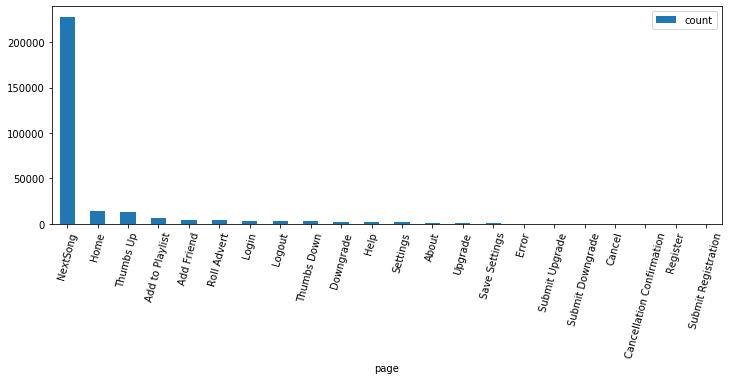

In [89]:
# The same ina graphical representation
df.groupby('page').count().sort('count', ascending=False) \
.toPandas().plot.bar(x='page', y='count', rot=75, figsize=(12,4));

In [90]:
# The 'method' column gas two values
df.groupby('method').count().sort('count', ascending=[False])

method,count
PUT,261064
GET,25436


In [91]:
# We have 3 status:
df.groupby('status').count().sort('count', ascending=[False])

status,count
200,259812
307,26430
404,258


In [181]:
# let's check the 'userAgent' column
df.select('userAgent').show(5, False)

+---------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                      |
+---------------------------------------------------------------------------------------------------------------+
|Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                       |
|"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"|
|Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                       |
|"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"|
|Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                       |
+---------------------------------------------------------------------------------------

In [190]:
def parse_userAgent(df):
    df = df.withColumn('os', regexp_extract(col('userAgent'), r'\((\w+);?\s+', 1))

    df = df.withColumn('browser', regexp_extract(col('userAgent'), r'\s(\w+)/\d+.\d+"?$', 1))
    
    df = df.withColumn('os', when(df['os'] == '', 'Undefined').otherwise(df['os']))
    
    df = df.withColumn('browser', when(df['browser'] == '', 'Undefined').otherwise(df['browser']))
    return df

In [191]:
df = parse_userAgent(df)

In [192]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = false)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = false)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = false)
 |-- userId: string (nullable = true)
 |-- state: string (nullable = true)
 |-- ts_date: date (nullable = true)
 |-- os: string (nullable = false)
 |-- browser: string (nullable = false)



In [211]:
df.groupby('os').count().sort('count', ascending=[False])

os,count
Windows,133187
Macintosh,102749
iPad,11381
iPhone,11192
compatible,10684
X11,8961
Undefined,8346


In [212]:
df.groupby('browser').count().sort('count', ascending=[False])

browser,count
Safari,168164
Undefined,62690
Firefox,55646


In [101]:
df.select(df.ts, length(df.ts)).show(5, False)

+-------------+----------+
|ts           |length(ts)|
+-------------+----------+
|1538352117000|13        |
|1538352180000|13        |
|1538352394000|13        |
|1538352416000|13        |
|1538352676000|13        |
+-------------+----------+
only showing top 5 rows



In [97]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = false)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = false)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- state: string (nullable = true)



In [207]:
# We do have the 'ts' in miliseconds, as it is 13 digits long, so we need to first
# convert it to seconds dividing it by 1000. Then convert it to a unix timestamp to
# use 'to_date' function to finally convert the result to a date we can use.
df = df.withColumn('ts_date', to_date(from_unixtime(col('ts') / 1000, 'yyyy-MM-dd HH:mm:ss')))

In [208]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = false)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = false)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = false)
 |-- userId: string (nullable = true)
 |-- state: string (nullable = true)
 |-- ts_date: date (nullable = true)
 |-- os: string (nullable = false)
 |-- browser: string (nullable = false)
 |-- churn: integer (nullable = false)



In [209]:
df.show(5,False)

+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+------+----------+-------+-------+-----+
|artist          |auth     |firstName|gender|itemInSession|lastName|length   |level|location                      |method|page    |registration |sessionId|song                         |status|ts           |userAgent                                                                                                      |userId|state |ts_date   |os     |browser|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+--------------------------------------------------------------

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [205]:
df = df.withColumn('churn', when(df['page'] == 'Cancellation Confirmation', 1).otherwise(0))
df = df.withColumn('churn', when(df['page'] == 'Submit Downgrade', 1).otherwise(df['churn']))

In [206]:
df.groupby('churn').count().sort('count', ascending=[False])

churn,count
0,286385
1,115


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.